<a href="https://colab.research.google.com/github/digs1998/Audio-Classification-Cats-and-Dogs/blob/main/Vegam_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import librosa.display as lbd
import librosa 
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import scipy.io.wavfile as sci_wav
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Deep learning task-20210403T043535Z-001/Deep learning task/train_test_split.csv')
train_data.head(4)

,Unnamed: 0,test_cat,test_dog,train_cat,train_dog
0,0,cat_22.wav,dog_barking_97.wav,cat_99.wav,dog_barking_33.wav
1,1,cat_116.wav,dog_barking_0.wav,cat_54.wav,dog_barking_86.wav
2,2,cat_155.wav,dog_barking_93.wav,cat_34.wav,dog_barking_45.wav
3,3,cat_58.wav,dog_barking_10.wav,cat_132.wav,dog_barking_76.wav


In [ ]:
#making training, test separate dfs
cat_train = train_data[['train_cat']].dropna().rename(index=str, columns={"train_cat":"file"}).assign(label=0)

dog_train = train_data[['train_dog']].dropna().rename(index=str, columns={"train_dog":"file"}).assign(label=1)

cat_test = train_data[['test_cat']].dropna().rename(index=str, columns={"test_cat":"file"}).assign(label=0)

dog_test = train_data[['test_dog']].dropna().rename(index=str, columns={"test_dog":"file"}).assign(label=1)

## concatenate all
train_df = pd.concat([cat_train, dog_train]).reset_index(drop=True)
test_df = pd.concat([cat_test, dog_test]).reset_index(drop=True)

In [ ]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)
df

,file,label
0,cat_99.wav,0
1,cat_54.wav,0
2,cat_34.wav,0
3,cat_132.wav,0
4,cat_124.wav,0
...,...,...
272,dog_barking_109.wav,1
273,dog_barking_69.wav,1
274,dog_barking_77.wav,1
275,dog_barking_60.wav,1


## MFCC processing
- The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification

In [ ]:
def features(file):
  y,sr = librosa.load(file, res_type='kaiser_fast')
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
  #applying transpose of mfcc and np.mean to get scaled value
  mfcc_scaled_feature = np.mean(mfccs.T, axis=0)
  return mfcc_scaled_feature

Now applying the function to all the wav files present


In [ ]:
from tqdm import tqdm 

audio_dataset_path='/content/drive/MyDrive/Deep learning task-20210403T043535Z-001/Deep learning task/full_dataset/'
extracted_features = []
for idx_num, row in tqdm(df.iterrows()):
  file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["file"]))
  final_class_labels=row["label"]
  data=features(file_name)
  extracted_features.append([data,final_class_labels])

277it [03:18,  1.40it/s]


In [ ]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-237.81186, 147.8731, -100.09769, -0.18745236...",0
1,"[-152.5646, 85.146255, -136.19484, 23.120811, ...",0
2,"[-316.7891, 126.741776, -5.3124957, -13.759399...",0
3,"[-288.4771, 93.19667, -31.311403, 7.1528773, -...",0
4,"[-274.62314, 73.78443, -53.000587, 81.18064, -...",0


**Now we split the data into dependent and independent sets**

In [ ]:
x = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

# Model Selection

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=45)
x_train.shape

(221, 40)

## Machine Learning Model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([ ('scaler', MinMaxScaler()),
                 ('classifier', RandomForestClassifier())])
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
pipe.score(x_test,y_test)

0.875

In [ ]:
y_pred = pipe.predict(x_test)

print('Classification Report \n{}'.format(sklearn.metrics.classification_report(y_test, y_pred)))

Classification Report 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        34
           1       1.00      0.68      0.81        22

    accuracy                           0.88        56
   macro avg       0.91      0.84      0.86        56
weighted avg       0.90      0.88      0.87        56



## Cross Val Score 

In [ ]:
cv=4
score = cross_val_score(pipe, x,y, cv=cv)
print('Cross-validation score for {cv} folds is \n{score}'.format(cv = cv, score = score))

Cross-validation score for 4 folds is 
[0.9        0.89855072 0.85507246 0.86956522]


## Confusion Matrix

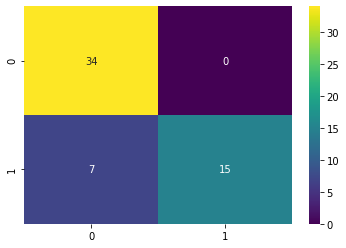

In [ ]:
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_pred),annot=True, cmap='viridis')

## ANN

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(40,)))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=64, verbose=1)

Epoch 1/15
4/4 [==============================] - 1s 70ms/step - loss: 11.1894 - accuracy: 0.4484 - val_loss: 0.9562 - val_accuracy: 0.6964
Epoch 2/15
4/4 [==============================] - 0s 17ms/step - loss: 8.0315 - accuracy: 0.5696 - val_loss: 0.6349 - val_accuracy: 0.7857
Epoch 3/15
4/4 [==============================] - 0s 17ms/step - loss: 7.3780 - accuracy: 0.5643 - val_loss: 0.6745 - val_accuracy: 0.7500
Epoch 4/15
4/4 [==============================] - 0s 16ms/step - loss: 5.8132 - accuracy: 0.6235 - val_loss: 0.5623 - val_accuracy: 0.8571
Epoch 5/15
4/4 [==============================] - 0s 17ms/step - loss: 6.5880 - accuracy: 0.6219 - val_loss: 0.6851 - val_accuracy: 0.7679
Epoch 6/15
4/4 [==============================] - 0s 21ms/step - loss: 4.8645 - accuracy: 0.6729 - val_loss: 0.9466 - val_accuracy: 0.7500
Epoch 7/15
4/4 [==============================] - 0s 16ms/step - loss: 5.9844 - accuracy: 0.5276 - val_loss: 1.0952 - val_accuracy: 0.7500
Epoch 8/15
4/4 [==========

In [ ]:
test_accuracy=model.evaluate(x_test,y_test,verbose=0)
print(test_accuracy[1])

0.8392857313156128


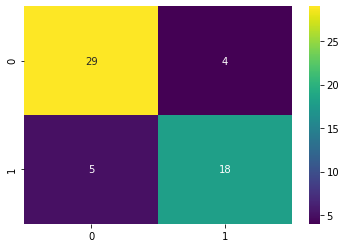

In [ ]:
sns.heatmap(sklearn.metrics.confusion_matrix(model.predict_classes(x_test), y_test),annot=True, cmap='viridis')

In [ ]:
print('Classification Report \n{}'.format(sklearn.metrics.classification_report(y_test, model.predict_classes(x_test))))

Classification Report 
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        34
           1       0.78      0.82      0.80        22

    accuracy                           0.84        56
   macro avg       0.83      0.84      0.83        56
weighted avg       0.84      0.84      0.84        56



# Models Testing on Data

## RandomForest Model

In [ ]:
from sklearn.preprocessing import LabelEncoder

filename="/content/drive/MyDrive/Deep learning task-20210403T043535Z-001/Deep learning task/full_dataset/dog_barking_0.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)


predicted_label=pipe.predict_proba(mfccs_scaled_features)
print(predicted_label)

[[0.11 0.89]]


## ANN Model

In [ ]:
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)


predicted_label=model.predict_classes(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[[1]]


array([1])